# Tarea 1

In [4]:
import pandas as pd 

# Escribir un script de Python o un notebook para cargar el conjunto de datos athlete_events.csv en un DataFrame.
print("="*100)
dir="./data/"
dict_data_types={"Name":"object",
                "Sex":"object",
                "Age":"float",
                "Height":"float",
                "Weight":"float",
                "Team":"object",
                "NOC":"object",
                "Games":"object",
                "Year":"int",
                "Season":"object",
                "City":"object",
                "Sport":"object",
                "Event":"object",
                "Medal":"object"
}
dict_nombre_columnas={'Name' : 'Nombre',
                    'Sex' : 'Sexo',
                    'Age' : 'Edad',
                    'Height' : 'Altura',
                    'Weight' : 'Peso',
                    'Team' : 'Equipo',
                    'NOC' : 'NOC',
                    'Games' : 'Olimpiada',
                    'Year' : 'Año',
                    'Season' : 'Temporada',
                    'City' : 'Ciudad',
                    'Sport' : 'Deporte',
                    'Event' : 'Evento',
                    'Medal' : 'Medalla'
}
atletas_data = pd.read_csv(dir+"athlete_events.csv", dtype=dict_data_types)
atletas_data=atletas_data.drop(columns=["ID"])   # Eliminamos la columna "ID" puesto que no aporta información
atletas_data=atletas_data.rename(columns=dict_nombre_columnas)


# Mostrar las dimensiones del DataFrame (número de filas y columnas). 
print("="*100)
dim_data=atletas_data.shape
print(f"Cantidad de filas {dim_data[0]},\nCantidad de columnas {dim_data[1]}")

# Mostrar los tipos de datos de cada columna. 
print("="*100)
atletas_data.info()

# Mostrar las primeras 10 filas del DataFrame. 
print("="*100)
print(atletas_data.head(10))
# print(atletas_data.sample(10)) Aunque prefiero usar sample porque es aleatorio

# Proporcionar un recuento de valores únicos para Year, Season, Sport y Medal. 
print("="*100)
# Distribución de variables categóricas
for col in ["Año", "Temporada", "Deporte", "Medalla"]:
    print("-"*100)
    print(atletas_data[col].value_counts().sort_index(ascending=True))


Cantidad de filas 271116,
Cantidad de columnas 14
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Nombre     271116 non-null  object 
 1   Sexo       271116 non-null  object 
 2   Edad       261642 non-null  float64
 3   Altura     210945 non-null  float64
 4   Peso       208241 non-null  float64
 5   Equipo     271116 non-null  object 
 6   NOC        271116 non-null  object 
 7   Olimpiada  271116 non-null  object 
 8   Año        271116 non-null  int64  
 9   Temporada  271116 non-null  object 
 10  Ciudad     271116 non-null  object 
 11  Deporte    271116 non-null  object 
 12  Evento     271116 non-null  object 
 13  Medalla    39783 non-null   object 
dtypes: float64(3), int64(1), object(10)
memory usage: 29.0+ MB
                     Nombre Sexo  Edad  Altura  Peso          Equipo  NOC  \
0                 A Dijiang    M  24.0   1

In [5]:
# Identificar columnas con valores faltantes e informar el porcentaje de valores 
print("="*100)
def total_null(atletas_data):
    data_null=atletas_data.isnull().sum()
    data_null=data_null.reset_index()
    data_null.columns = ["Columna", "Nulos"]
    data_null=data_null.loc[data_null["Nulos"]>0,:]
    data_null["Porcentaje(%)"] = round((data_null["Nulos"] / len(atletas_data)) * 100,2)

    print(data_null.sort_values(by="Porcentaje(%)", ascending=False))

total_null(atletas_data)

    Columna   Nulos  Porcentaje(%)
13  Medalla  231333          85.33
4      Peso   62875          23.19
3    Altura   60171          22.19
2      Edad    9474           3.49


## Imputar valores faltantes utilizando una estrategia razonable. Justificar decision.

Del item anterior podemos inferir que existen cinco situaciones para cuatro variables por la cuál podría estar nulo, puesto que aproximadamente Height y Weight tienen el mismo porcentaje.

**Caso columna "Age":**  
Sólo tiene el $3.49\%$ de los datos nulos, entonces como es un porcentaje pequeño podemos suponer que estos datos no son significativos al momento de entrenar un modelo. Así, podemos eliminar las filas cuya columna "Age" sea nula.

**Caso columnas "Height" y "Weight":**  
Cuando las columnas "Height" y "Weight" son valores nulos podemos suponer que es debido a la misma situación, por lo tanto debemos tratarlos de la misma forma. Como son datos de atletas en diferentes deportes de distintos paises y edades, entonces podemos usar el promedio en función de ("sport", "NOC","sex","age") puesto que el cuerpo de la persona varia en estas variables. Por ejemplo, una persona que hace maraton no tiene el mismo cuerpo que la persona que hace football. Las personas también varían por NOC (país), por ejemplo una persona de dinamarca tiende a ser alta, pero en Asia tienden a ser más pequeñas. Finalmente, los hombres tienden a pesar más y ser más altos que las mujeres. Para el caso de la edad, se definiran rangos de edad en donde se supone que no varían demasiado los pesos y alturas de las atletas. Los rango de edades se forman puesto que necesitamos pasar una variable discreta a categorica y porque si lo hacemos por edad los grupos serían demasiado pequeños.

En resumen, imputaremos con el promedio de la agrupación del tipo ("sport", "NOC","sex","Edad_rango"). Obviamente, no se imputaran todas las filas necesarias, si que proseguiremos agrupando por ("sport","sex","Edad_rango"), ("NOC","Sexo","Edad_rango") y finalmente por ("Sexo","Edad_rango").

**Caso columnas "Medalla":**  
Del item anterior, podemos ver que los posibles valores de la columna medalla son: 
- Bronze,
- Gold y
- Silver.  

Por lo tanto, podemos suponer que no se registran o se deja en blanco cuando la persona no obtiene alguna medalla. De este modo, llenaremos los valores null con la etiqueta "Ninguna".

In [6]:
# Imputación Promedio Peso y Altura
def imputacion_prom_altura_peso(atletas_data, col_indep):

    bins = [7, 12, 17, 25, 40, 60, 200]
    labels = ["8-12","13-17","18-25","26-40","41-60","61-inf"]
    atletas_data["Edad_rango"] = pd.cut(atletas_data["Edad"], bins=bins, labels=labels)
    
    col_objs=["Altura", "Peso"]
    total_cols = col_indep + col_objs

    atletas_clean = atletas_data.dropna(subset=total_cols)

    # Agrupar y calcular media de altura y peso
    agg_atletas_clean = (atletas_clean.groupby(by=col_indep)
                                    .agg(
                                        media_altura=(col_objs[0], "mean"),
                                        media_peso=(col_objs[1], "mean"),
                                    ).reset_index())

    # Hacer merge y rellenar valores nulos # NOTAR QUE LA LISTA col_indep es una key para agg_atletas_clean
    atletas_data_merge = atletas_data.merge(agg_atletas_clean, on=col_indep, how='left')

    atletas_data_merge['Altura'] = atletas_data_merge['Altura'].fillna(atletas_data_merge['media_altura'])
    atletas_data_merge['Peso'] = atletas_data_merge['Peso'].fillna(atletas_data_merge['media_peso'])
    atletas_data_corregido = atletas_data_merge.drop(columns=["media_altura","media_peso","Edad_rango"] )
    
    return atletas_data_corregido

# Eliminacion de valores nulos de la Edad (Se elimina primero porque la altura depende de la edad)
atletas_data_corregido = atletas_data.dropna(subset=["Edad"])

# Imputación Altura y Peso
col_indep=["Deporte","NOC","Sexo","Edad_rango"]
atletas_data_corregido=imputacion_prom_altura_peso(atletas_data_corregido,col_indep)

col_indep=["Deporte","Sexo","Edad_rango"]
atletas_data_corregido=imputacion_prom_altura_peso(atletas_data_corregido, col_indep)

col_indep=["NOC","Sexo","Edad_rango"]
atletas_data_corregido=imputacion_prom_altura_peso(atletas_data_corregido,col_indep)

col_indep=["Sexo","Edad_rango"]
atletas_data_corregido=imputacion_prom_altura_peso(atletas_data_corregido,col_indep)

# Eliminacion de valores nulos de la Edad
atletas_data_corregido['Medalla'] = atletas_data_corregido['Medalla'].fillna("Ninguna")
atletas_data_corregido["Altura"]=atletas_data_corregido["Altura"].round(2)
atletas_data_corregido["Peso"]=atletas_data_corregido["Peso"].round(2)

# total_null(atletas_data_corregido) # Puedes usar esta función para ver si existen valores null
atletas_data_corregido

C:\Users\Nach\AppData\Local\Temp\ipykernel_17404\2429502472.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atletas_data["Edad_rango"] = pd.cut(atletas_data["Edad"], bins=bins, labels=labels)
C:\Users\Nach\AppData\Local\Temp\ipykernel_17404\2429502472.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_atletas_clean = (atletas_clean.groupby(by=col_indep)
C:\Users\Nach\AppData\Local\Temp\ipykernel_17404\2429502472.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed

,Nombre,Sexo,Edad,Altura,Peso,Equipo,NOC,Olimpiada,Año,Temporada,Ciudad,Deporte,Evento,Medalla
0,A Dijiang,M,24.0,180.00,80.00,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,Ninguna
1,A Lamusi,M,23.0,170.00,60.00,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,Ninguna
2,Gunnar Nielsen Aaby,M,24.0,182.93,76.17,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,Ninguna
3,Edgar Lindenau Aabye,M,34.0,184.52,96.19,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,Christine Jacoba Aaftink,F,21.0,185.00,82.00,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,Ninguna
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261637,Andrzej ya,M,29.0,179.00,89.00,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,Ninguna
261638,Piotr ya,M,27.0,176.00,59.00,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",Ninguna
261639,Piotr ya,M,27.0,176.00,59.00,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",Ninguna
261640,Tomasz Ireneusz ya,M,30.0,185.00,96.00,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,Ninguna


## Validar si existen filas duplicadas o generadas por una combinación sensata de columnas y decidir si esas se eliminan o se preservan. Justificar decision.

Si pensamos en normalizar la tabla, podemos entender que existen al menos tres entidades, [Atleta, Deporte, Evento]. Por lo tanto, podemos formar una primary key para cada una de estas entidades, concatenarlas y formaremos una primary key de la tabla. 

**Para Atletas.**  
Consideramos algunos ejemplos:
- Nombre y sexo como clave.  
Esto es insuficiente, puesto que existe un él atleta llamado "Yang Wei" y una atleta llamada de la misma forma.

- Nombre, Sexo y Edad como clave.  
Esto es insuficiente, puesto que existen dos atletas llamados "Balbir Singh" con estas atributos.

Por lo tanto, se postula la siguiente primary key para los atletas (Nombre, Sexo, Edad, Altura).

**Para Deporte**  
Sólo basta con la columna (Deporte).

**Para Evento**  
Sólo basta con las columnas (Año, Evento)

Luego, concatenamos estas claves, y nos fijamos que exite un atleta llamado "Adolf Mller", la cuál tiene un doble registro, uno con medalla y el otro no. De este modo, Mantendremos la primary formada, pero dejaremos los datos que tiene la medalla de mayor valor.

Notar que los eventos asociados al Deporte llamado "Art Competitions" es poco especifico, puesto que existen muchas categorias de eventos asociadas a este deporte y algunos son desconocidos. Aún así, aplicaremos la misma clave primaria.

In [7]:
def Medalla_order(row_j):
    if row_j=="Gold":
        value=f"1_{row_j}"
    elif row_j=="Silver":
        value=f"2_{row_j}"
    elif row_j=="Bronze":
        value=f"3_{row_j}"
    else:
        value=f"4_{row_j}"
    return value
        
atletas_data_corregido["Ordenada_Medalla"]=atletas_data_corregido.apply(lambda row: Medalla_order(row["Medalla"]), axis=1)
atletas_data_corregido = atletas_data_corregido.sort_values(by="Ordenada_Medalla", ascending=True)
atletas_data_corregido = atletas_data_corregido.drop_duplicates(subset=["Nombre","Edad","Altura","Sexo","Año","Deporte","Evento","Equipo"],keep="first" )
atletas_data_corregido = atletas_data_corregido.drop(columns=["Ordenada_Medalla"] )


# Tarea 3

In [8]:
# Crear una nueva columna Decade a partir de la columna Year (ej., 1980s, 1990s,2000s, 2010s). 
atletas_data_corregido["Decade"]=atletas_data_corregido["Año"]//10*10

# Crear una nueva columna BMI (Índice de Masa Corporal) 
atletas_data_corregido["BMI"]=atletas_data_corregido["Peso"]/(atletas_data_corregido["Altura"]/100)**2
atletas_data_corregido["BMI"]=atletas_data_corregido["BMI"].round(2)


# Filtrar el conjunto de datos para incluir solo a los atletas que participaron en los Juegos Olímpicos de "Summer". 
cond1=atletas_data_corregido["Temporada"]=="Summer"
filtered_atletas_data = atletas_data_corregido.loc[cond1,:]
filtered_atletas_data=filtered_atletas_data.reset_index(drop=True)
filtered_atletas_data

,Nombre,Sexo,Edad,Altura,Peso,Equipo,NOC,Olimpiada,Año,Temporada,Ciudad,Deporte,Evento,Medalla,Decade,BMI
0,Ding Meiyuan,F,20.0,168.0,102.00,China,CHN,2000 Summer,2000,Summer,Sydney,Weightlifting,Weightlifting Women's Super-Heavyweight,Gold,2000,36.14
1,Aaron Wells Peirsol,M,21.0,191.0,91.00,United States,USA,2004 Summer,2004,Summer,Athina,Swimming,Swimming Men's 4 x 100 metres Medley Relay,Gold,2000,24.94
2,Maria Claudia Prescan,F,20.0,156.0,42.00,Romania,ROU,2000 Summer,2000,Summer,Sydney,Gymnastics,Gymnastics Women's Team All-Around,Gold,2000,17.26
3,Aaron Wells Peirsol,M,21.0,191.0,91.00,United States,USA,2004 Summer,2004,Summer,Athina,Swimming,Swimming Men's 200 metres Backstroke,Gold,2000,24.94
4,Aaron Wells Peirsol,M,21.0,191.0,91.00,United States,USA,2004 Summer,2004,Summer,Athina,Swimming,Swimming Men's 100 metres Backstroke,Gold,2000,24.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212081,Derek Holland,M,22.0,186.0,79.14,Ireland,IRL,1996 Summer,1996,Summer,Atlanta,Rowing,Rowing Men's Lightweight Coxless Fours,Ninguna,1990,22.88
212082,John Macfarlane Holland,M,21.0,191.0,81.00,New Zealand,NZL,1948 Summer,1948,Summer,London,Athletics,Athletics Men's 400 metres Hurdles,Ninguna,1940,22.20
212083,John Adams Holland,M,20.0,183.0,80.00,United States,USA,1972 Summer,1972,Summer,Munich,Canoeing,"Canoeing Men's Kayak Singles, Slalom",Ninguna,1970,23.89
212084,Koby Holland,M,29.0,185.0,83.00,United States,USA,2004 Summer,2004,Summer,Athina,Shooting,"Shooting Men's Running Target, 10 metres",Ninguna,2000,24.25


# Tarea 4

In [9]:
# Obtener los 3 deportes más populares
cond1=filtered_atletas_data["Año"]>=2000
cond2=filtered_atletas_data["Temporada"]=="Summer"

popularidad_deportes=(filtered_atletas_data.loc[(cond1 & cond2) ,:]
                                                     .groupby(by=["Deporte"])
                                                     .agg(conteo_atletas=("Deporte", "count"))
                                                     .reset_index()
                                                     .sort_values(by="conteo_atletas", ascending=False)
)
top_3_deportes=popularidad_deportes["Deporte"].head(3).values

# Obtener la edad promedio de los atletas ganadores del oro ...
cond1=filtered_atletas_data["Medalla"]=="Gold"
cond2=filtered_atletas_data["Año"]>=2000
cond3=filtered_atletas_data["Temporada"]=="Summer"
cond4=filtered_atletas_data["Deporte"].isin(top_3_deportes)

prom_edad_top_3_deportes=round(filtered_atletas_data[(cond1 & cond2 & cond3 & cond4 )].groupby(by="Deporte").agg(prom_edad=("Edad","mean")).reset_index(),2)


# Tarea 5

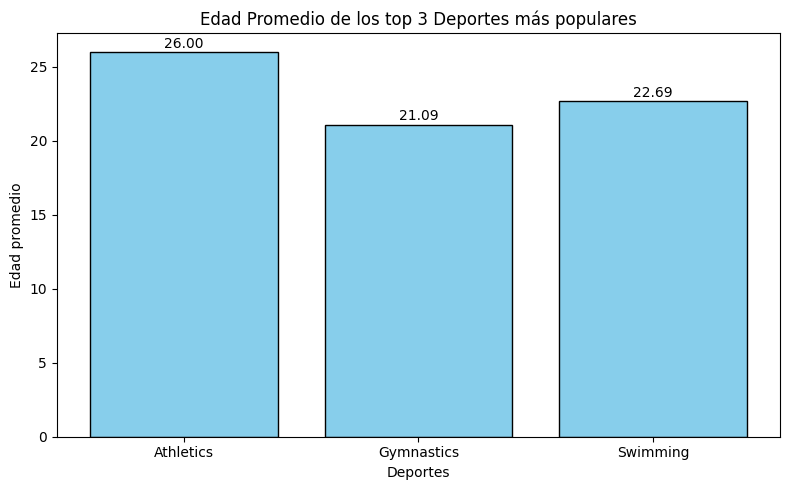

In [10]:
import matplotlib.pyplot as plt

# Gráfica de barras
plt.figure(figsize=(8, 5))
bars = plt.bar(prom_edad_top_3_deportes["Deporte"], prom_edad_top_3_deportes["prom_edad"], color="skyblue", edgecolor="black")

# Etiquetas y título
plt.xlabel("Deportes")
plt.ylabel("Edad promedio")
plt.title("Edad Promedio de los top 3 Deportes más populares")

# Mostrar valores encima de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f"{yval:.2f}", 
             ha="center", va="bottom")


plt.tight_layout()
plt.show()

De este gráfico se puede inferir la "mejor" edad de los atletas pertenecientes a estas tres disciplinas. Podemos ver que "Athletics" es el deporte que más se demora en llegar al pico del rendimiento, mientras que "Gymnastics" es la inferior.

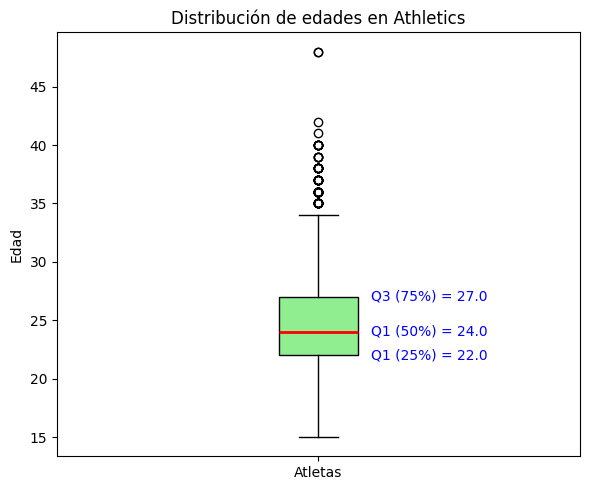

In [11]:
import numpy as np
# Un histograma o diagrama de caja (box plot) que muestre la distribución de Age ...
cond1=filtered_atletas_data["Medalla"]!="Ninguna"
cond2=filtered_atletas_data["Temporada"]=="Summer"
cond3=filtered_atletas_data["Deporte"]=="Athletics"
edades=filtered_atletas_data.loc[(cond1 & cond2 & cond3),"Edad"].values

q1 = np.percentile(edades, 25)
q2 = np.percentile(edades, 50)
q3 = np.percentile(edades, 75)

plt.figure(figsize=(6, 5))
plt.boxplot(edades, vert=True, patch_artist=True,
            boxprops=dict(facecolor="lightgreen", color="black"),
            medianprops=dict(color="red", linewidth=2))

plt.title("Distribución de edades en Athletics")
plt.ylabel("Edad")
plt.xticks([1], ["Atletas"])

# Anotar Q1 y Q3
plt.text(1.1, q1, f"Q1 (25%) = {q1}", va="center", color="blue")
plt.text(1.1, q2, f"Q1 (50%) = {q2}", va="center", color="blue")
plt.text(1.1, q3, f"Q3 (75%) = {q3}", va="center", color="blue")

plt.tight_layout()
plt.show()

La mediana de las edades de los atletas que ganaron medallas es 24 años. Los atletas entre 22 y los 27 son el $50\%$ de las atletas que tienen medallas. Por lo tanto, si seleccionamos de los datos una atleta aleatoria que haya ganado una medalla, entonces tenemos $50\%$ que tenga una edad entre 22 y los 27.

# Tarea 6

In [12]:
import os
dir="./results"
os.makedirs(dir, exist_ok=True)
filtered_atletas_data.to_csv(dir+"/"+"cleaned_olympic_data.csv", header=True, sep=',', index=False, encoding="latin1")
prom_edad_top_3_deportes.to_json(dir+"/"+"olympic_kpi.json", orient="records", force_ascii=False, indent=4)